# Spatial Interpolation at Big Bend

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio contextily
`

**Note: installation of geopandas may take a few hours**

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Preprocess](#preprocess)
* [3. Combine Data](#read_data)
* [4. Spatial Interpolation of Dissolved Oxygen](#do_interpolate)
    * [4.1 Kriging:Dissolved Oxygen](#do_kriging)
    * [4.2 IDW:Dissolved Oxygen](#do_idw)
    * [4.3 Empirical Bayesian Kriging:Dissolved Oxygen](#do_ebk)
    * [4.4 Regression Kriging:Dissolved Oxygen](#do_rk)
* [5. Interpolation Validation of Dissolved Oxygen](#do_validation)
    * [5.1 Validation of Kriging:Dissolved Oxygen](#do_val_kriging)
    * [5.2 Validation of IDW:Dissolved Oxygen](#do_val_idw)
    * [5.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#do_val_ebk)
    * [5.4 Validation of Regression Kriging:Dissolved Oxygen](#do_val_rk)
    * [5.5 Validation Summary:Dissolved Oxygen](#do_val_sum) 
* [6. Spatial Interpolation of Salinity](#s_interpolate)
    * [6.1 Kriging:Dissolved Oxygen](#s_kriging)
    * [6.2 IDW:Dissolved Oxygen](#s_idw)
    * [6.3 Empirical Bayesian Kriging:Dissolved Oxygen](#s_ebk)
    * [6.4 Regression Kriging:Dissolved Oxygen](#s_rk)
* [7. Interpolation Validation of Salinity](#s_validation)
    * [7.1 Vlidation of Ordinary Kriging:Dissolved Oxygen](#s_val_kriging)
    * [7.2 Validation of IDW:Dissolved Oxygen](#s_val_idw)
    * [7.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#s_val_ebk)
    * [7.4 Validation of Regression Kriging:Dissolved Oxygen](#s_val_rk)
    * [7.5 Summary of Validation:Dissolved Oxygen](#s_val_sum)
* [8. Spatial Interpolation of Total Nitrogen](#tn_interpolate)
    * [8.1 Kriging:Total Nitrogen](#tn_kriging)
    * [8.2 IDW:Total Nitrogen](#tn_idw)
    * [8.3 Empirical Bayesian Kriging:Total Nitrogen](#tn_ebk)
    * [8.4 Regression Kriging:Total Nitrogen](#tn_rk)
* [9. Interpolation Validation of Total Nitrogen](#tn_validation)
    * [9.1 Vlidation of Kriging:Total Nitrogen](#tn_val_kriging)
    * [9.2 Validation of IDW:Total Nitrogen](#tn_val_idw)
    * [9.3 Validation of Empirical Bayesian Kriging:Total Nitrogen](#tn_val_ebk)
    * [9.4 Validation of Regression Kriging:Total Nitrogen](#tn_val_sum)
* [10 Summary of Validation](#val_sum)

In [1]:
import time
import math  
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
import os
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [2]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [3]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [4]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


# dry_start,dry_end = '11/01/2016','04/30/2017'
# wet_start,wet_end = '05/01/2017','10/31/2017'

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [6]:
# Set variables of the program
year = "2017"
Area = 'Big Bend Seagrasses Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'
b_name = 'bb'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'
boundary_shp = gis_path+ '{}.shp'.format(b_name)

# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_50480\1992034854.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_50480\1992034854.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [7]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll['geometry'] = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll['geometry'] = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Read Input Data <a class="anchor" id="read_data"></a>
## 3.1 Load Managed Area Polygon

In [8]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

## 3.2 Load Point Shapefiles

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [9]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp )

Text(0.5, 1.0, 'Sampling points at Big Bend Seagrasses Aquatic Preserve')

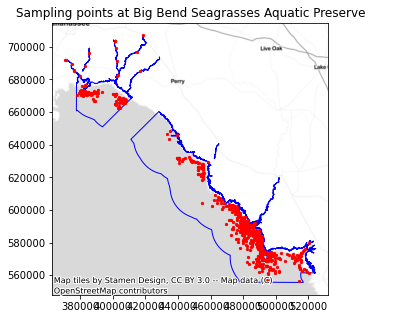

In [10]:
fig, ax = plt.subplots(figsize = (9,5))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [11]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')


# 4. Spatial Interpoation of Dissolved Oxygen <a class="anchor" id="do_interpolate"></a>

## 4.1 Ordinary Kriging: Dissolved Oxygen <a class="anchor" id="do_kriging"></a>

Run Oridinary Kriging for dry season data

In [13]:
year, season, method, value_field, mask = '2017', 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2017, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK_2017,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

Interpolation using the Ordinary Kriging method
Interpolation using the Ordinary Kriging method


Plot the interpolation result

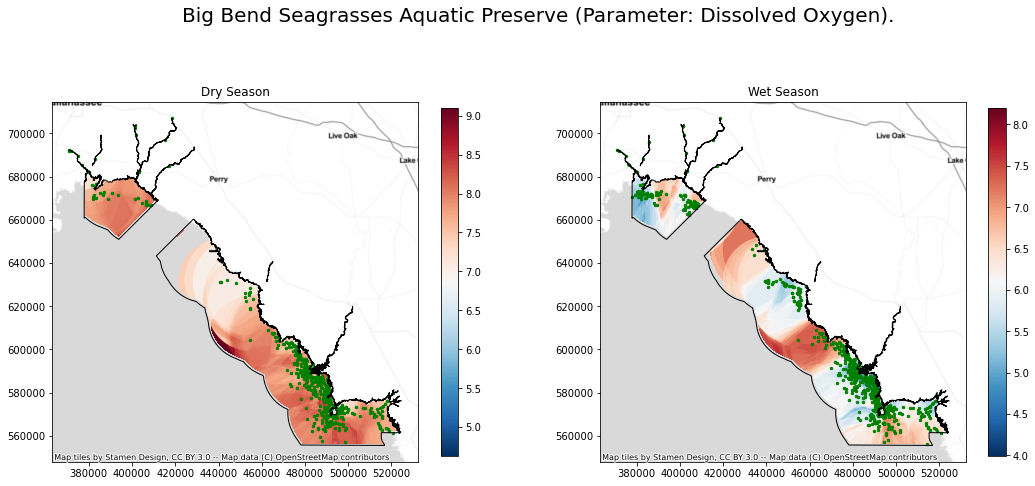

In [14]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2017, 'Wet Season', axes[1], fig)

## 4.2 Inverse Distance Weighting (IDW): Dissolved Oxygen <a class="anchor" id="do_idw"></a>

Run IDW for both wet and dry seasons

In [19]:
year, season, method, value_field, mask = '2017', 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 28.21045470237732 seconds ---
Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 28.606093645095825 seconds ---


Plot the interpolation result

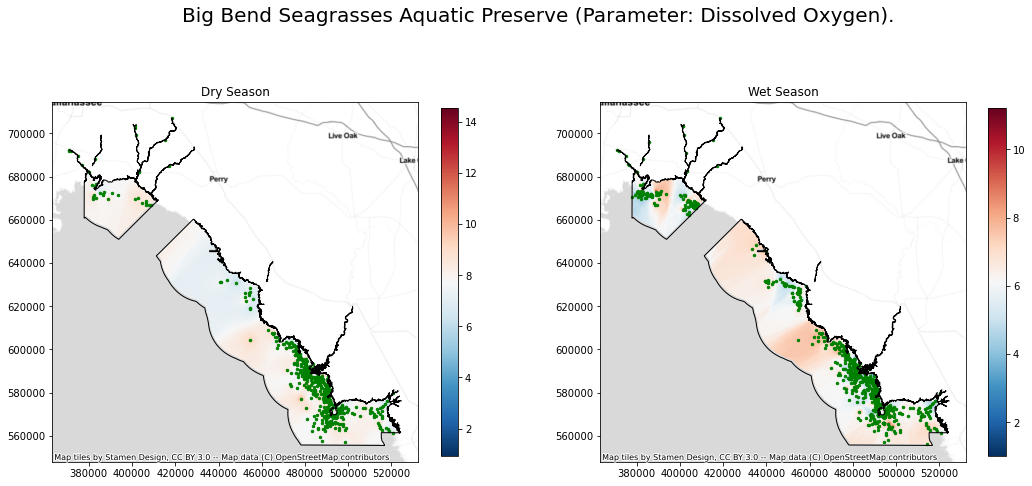

In [20]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2017, 'Wet Season', axes[1],fig)


## 4.3 Empirical Bayesian Kriging (EBK) <a class="anchor" id="do_ebk"></a>

Run EBK for wet and dry seasons

In [21]:
year, season, method, value_field, mask = '2017', 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 1282.2309370040894 seconds ---
Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 1903.6697142124176 seconds ---


Plot interpolation results

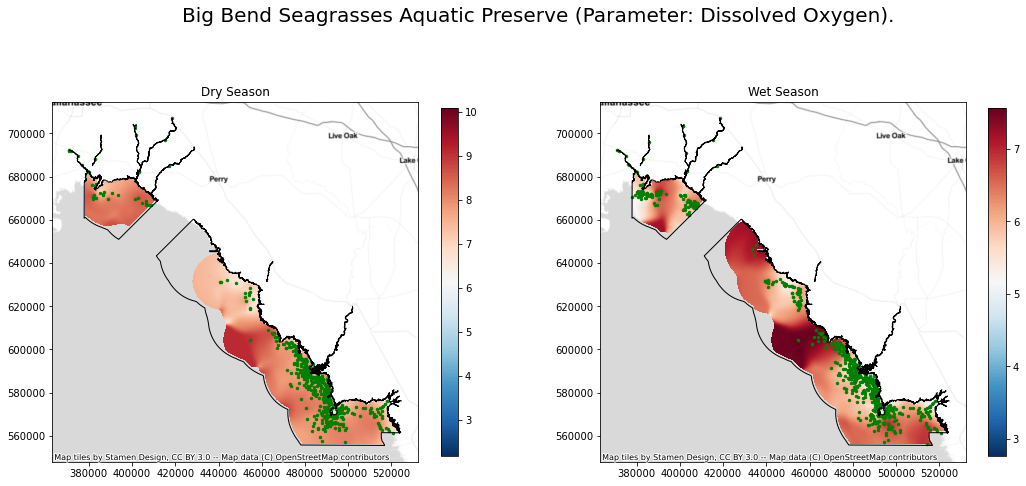

In [22]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2017, 'Wet Season', axes[1],fig)


## 4.4 Regression Kriging (RK) <a class="anchor" id="do_rk"></a>

Plot the covariate (bathymetry)

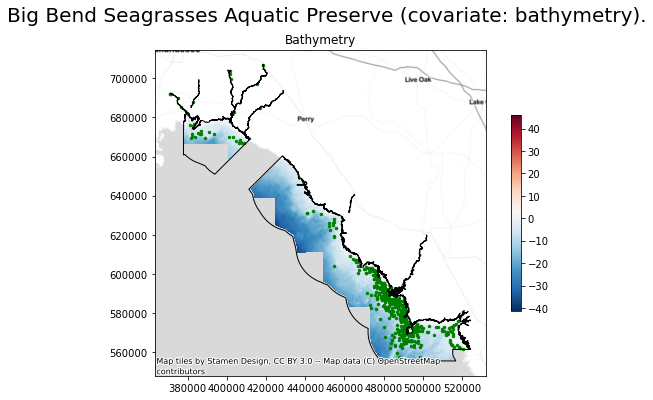

In [23]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(9, 6))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

Run regression kriging

In [24]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', boundary_shp 
in_explanatory_rasters = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])

in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 2219.6582453250885 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 2650.784217596054 seconds ---


Show interploation result

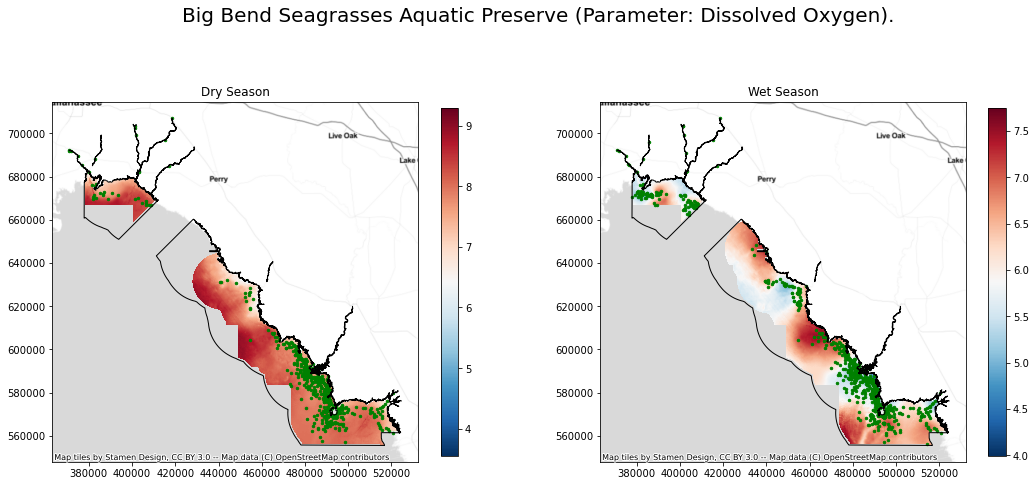

In [25]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)

# 5. Interpolation Validation (Dissolved Oxygen) <a class="anchor" id="do_validation"></a>
## 5.1 Validation: Ordinary Kriging <a class="anchor" id="do_val_kriging"></a>

In [26]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.001124,0.00038,1.168835


Interpolation assessment of Ordinary Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.011823,0.00437,1.451679


## 5.2 Validation: Inverse Distance Weighting (IDW) <a class="anchor" id="do_val_idw"></a>

In [27]:
method, season, index = 'idw', 'dry', 'Inverse Distance Weighting', 
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryIDWStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'idw', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetIDWStat = misc.interpolation.extract_val_result(inLayer,index)

In [28]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,-0.0339,NaN,1.2145


Interpolation assessment of Inverse Distance Weighting in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,0.0366,NaN,1.6063


## 5.3 Validation: Empirical Bayesian Kriging <a class="anchor" id="do_val_ebk"></a>

In [29]:
method, season, index = 'ebk', 'dry', 'Empirical Bayesian Kriging'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryEBKStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'ebk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetEBKStat = misc.interpolation.extract_val_result(inLayer,index)

In [30]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,-0.0106,-0.0099,1.1137


Interpolation assessment of Empirical Bayesian Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,-0.017,-0.0119,1.4374


## 5.4 Validation: Regression Kriging <a class="anchor" id="do_val_rk"></a>

In [31]:
method, season, index = 'rk', 'dry', 'Regression Kriging'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryRKStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'rk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetRKStat = misc.interpolation.extract_val_result(inLayer,index)

In [32]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,0.0406,0.0385,1.0932


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,-0.0006,-0.0001,1.4327


## 5.5 Summary of Validation (comparing four methods) <a class="anchor" id="do_val_sum"></a>

In [33]:
sumStatDry   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat,dryRKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry

Summary of interpolation assessment in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.001124,0.00038,1.168835
Inverse Distance Weighting,-0.033900,NaN,1.214500
Empirical Bayesian Kriging,-0.010600,-0.00990,1.113700
Regression Kriging,0.040600,0.03850,1.093200


In [34]:
sumStatWet = pd.concat([wetOKStat,wetIDWStat,wetEBKStat,wetRKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet

Summary of interpolation assessment in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.011823,0.00437,1.451679
Inverse Distance Weighting,0.036600,NaN,1.606300
Empirical Bayesian Kriging,-0.017000,-0.01190,1.437400
Regression Kriging,-0.000600,-0.00010,1.432700


# 6. Spatial Interpolation of Salinity <a class="anchor" id="s_interpolate"></a>

In [35]:

# dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
# dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

# dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
# dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Para, Para_ab, year = 'Salinity', 'S', '2017'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_50480\1911020262.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_50480\1911020262.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [36]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Big Bend Seagrasses Aquatic Preserve')

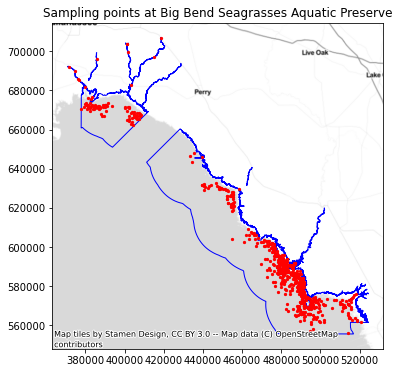

In [37]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 6.1 Ordinary Kriging (Salinity) <a class="anchor" id="s_ok"></a>

In [38]:
year, season, method, value_field, mask = '2017', 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2017, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                                         z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK_2017, wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                                         z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Ordinary Kriging method
Interpolation using the Ordinary Kriging method


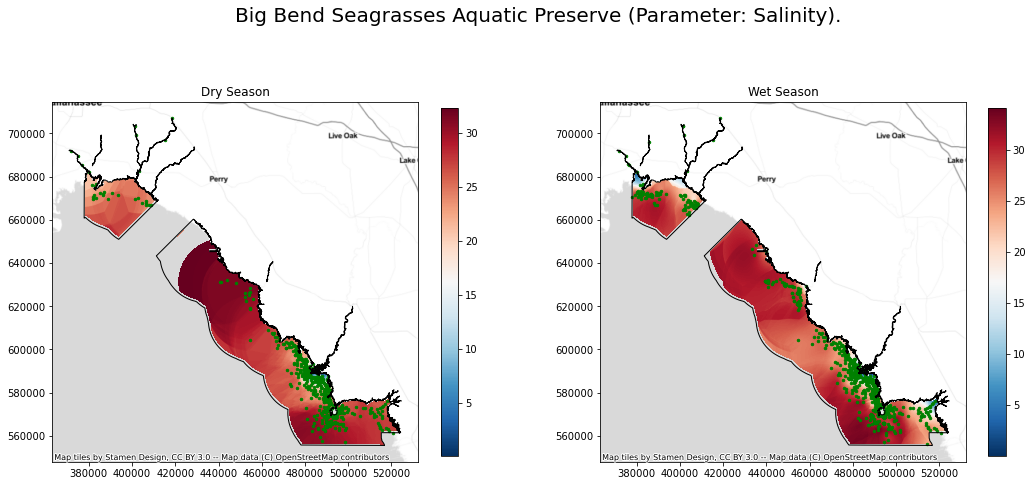

In [39]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2017, 'Wet Season', axes[1], fig)

## 6.2 Inverse Distance Weighting (IDW): Salinity <a class="anchor" id="s_idw"></a>

Run IDW for both wet and dry seasons

In [40]:
year, season, method, value_field, mask = '2017', 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 27.151561498641968 seconds ---
Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 27.40687656402588 seconds ---


Plot the interpolation result

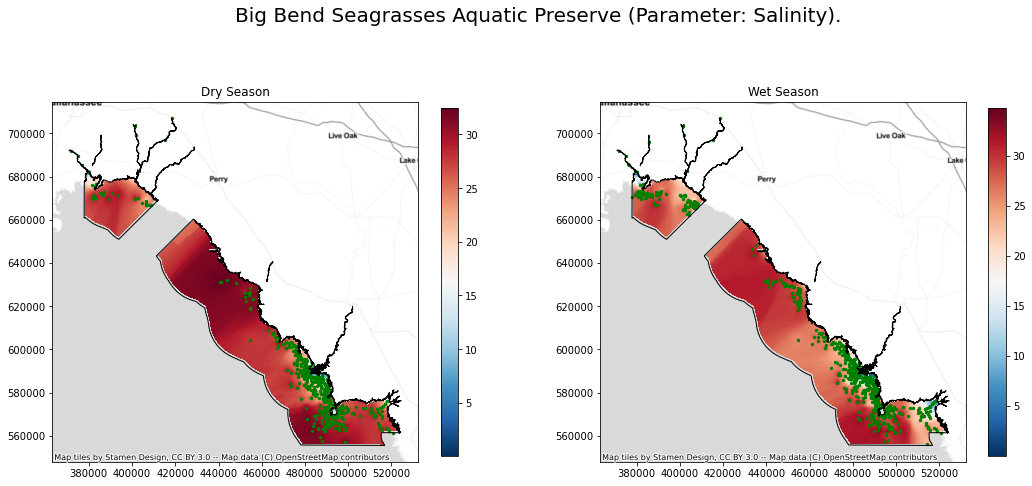

In [41]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2017, 'Wet Season', axes[1],fig)

## 6.3 Empirical Bayesian Kriging (EBK): Salinity <a class="anchor" id="s_ebk"></a>

Run EBK for wet and dry seasons

In [42]:
year, season, method, value_field, mask = '2017', 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, mask = mask)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                               z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, mask = mask)

Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 1150.2255442142487 seconds ---
Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 1509.1903030872345 seconds ---


Plot interpolation results

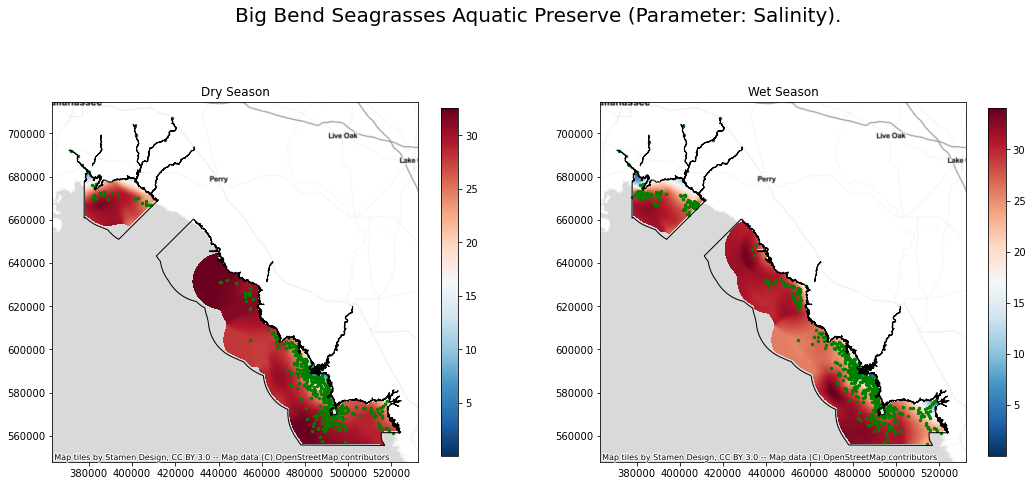

In [43]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2017, 'Wet Season', axes[1],fig)

## 6.4 Regression Kriging (RK): Salinity <a class="anchor" id="s_rk"></a>

Display covariates

In [44]:
year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', boundary_shp 
in_explanatory_rasters = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 1768.1011424064636 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 2062.682142972946 seconds ---


Display result

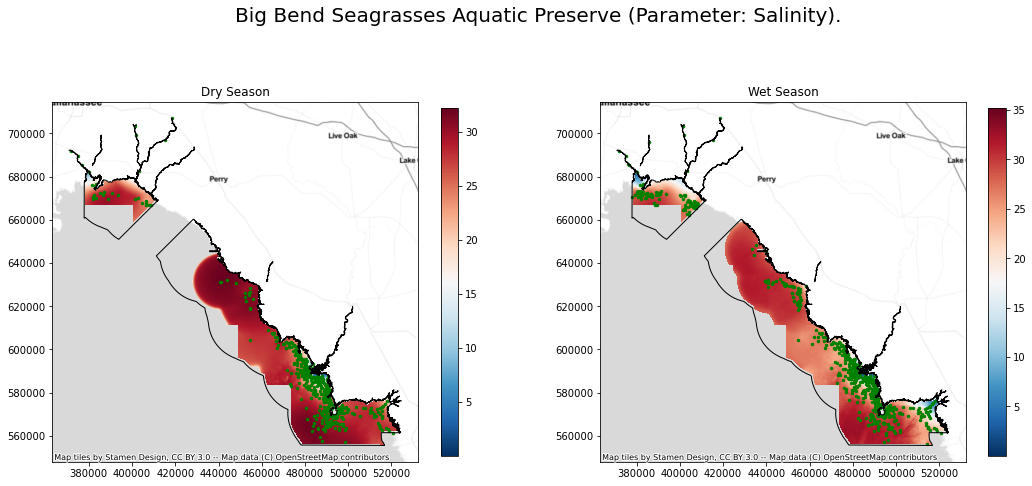

In [45]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)

# 7. Interpolation Validation: Salinity <a class="anchor" id="s_validation"></a>
## 7.1 Validation of Ordinary Kriging <a class="anchor" id="s_val_ok"></a>

In [46]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.063675,0.008914,3.432846


Interpolation assessment of Ordinary Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.063218,0.009662,3.557056


## 7.2 Validation of IDW: Salinity <a class="anchor" id="s_val_idw"></a>

In [47]:
method, season, index = 'idw', 'dry', 'Inverse Distance Weighting'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryIDWStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'idw', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetIDWStat = misc.interpolation.extract_val_result(inLayer,index)

In [48]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,-0.0264,NaN,4.0522


Interpolation assessment of Inverse Distance Weighting in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,-0.1616,NaN,4.1167


## 7.3 Validation of Empirical Bayesian Kriging: Salinity <a class="anchor" id="s_val_ebk"></a>

In [49]:
method, season, index = 'ebk', 'dry', 'Empirical Bayesian Kriging'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryEBKStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'ebk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetEBKStat = misc.interpolation.extract_val_result(inLayer,index)

In [50]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,0.0446,-0.0014,3.5155


Interpolation assessment of Empirical Bayesian Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,0.0536,0.005,3.5912


## 7.4 Validation of Regression Kriging: Salinity <a class="anchor" id="s_val_rk"></a>

In [51]:
method, season, index = 'rk', 'dry', 'Regression Kriging'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryRKStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'rk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetRKStat = misc.interpolation.extract_val_result(inLayer,index)

In [52]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,-0.0127,-0.014,3.4314


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,0.004,-0.0021,3.6051


## 7.5 Validation Summary: Salinity <a class="anchor" id="s_val_sum"></a>

In [53]:
sumStatDry2 = pd.concat([dryOKStat,dryIDWStat, dryEBKStat,dryRKStat])

print("Summary of interpolation assessment in dry season data")
sumStatDry2

Summary of interpolation assessment in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.063675,0.008914,3.432846
Inverse Distance Weighting,-0.026400,NaN,4.052200
Empirical Bayesian Kriging,0.044600,-0.001400,3.515500
Regression Kriging,-0.012700,-0.014000,3.431400


In [54]:
sumStatWet2 = pd.concat([wetOKStat,wetIDWStat, wetEBKStat,wetRKStat])

print("Summary of interpolation assessment in dry season data")
sumStatWet2

Summary of interpolation assessment in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.063218,0.009662,3.557056
Inverse Distance Weighting,-0.161600,NaN,4.116700
Empirical Bayesian Kriging,0.053600,0.005000,3.591200
Regression Kriging,0.004000,-0.002100,3.605100


# 8. Spatial Interpolation of Total Nitrogen <a class="anchor" id="tn_interpolate"></a>

Select and preview data

In [55]:
year,Para,Para_ab = "2014", 'Total Nitrogen', "TN"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_50480\217055082.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_50480\217055082.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [56]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Big Bend Seagrasses Aquatic Preserve')

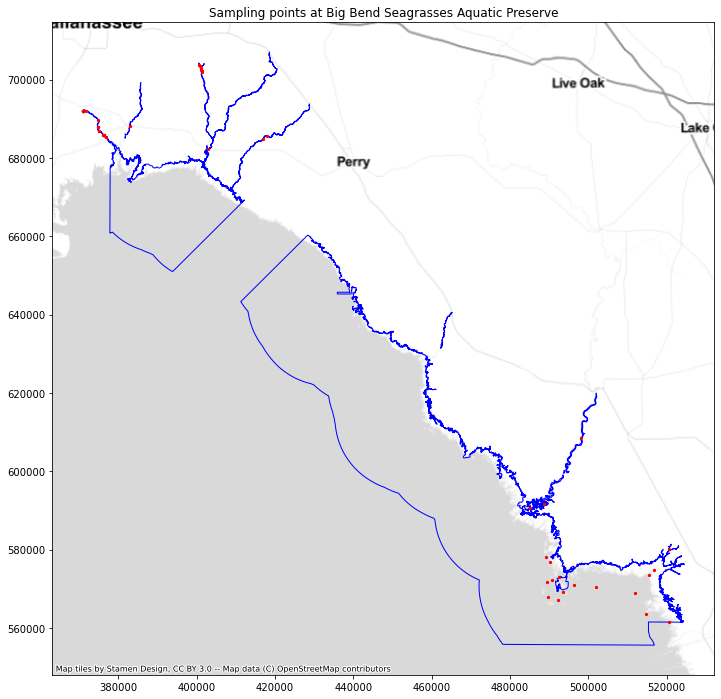

In [57]:
fig, ax = plt.subplots(figsize = (16,12))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 8.1 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_kriging"></a>

In [59]:
year, season, method, value_field, mask = '2014', 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2014, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())
wetOK_2014,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

Interpolation using the Ordinary Kriging method
Interpolation using the Ordinary Kriging method


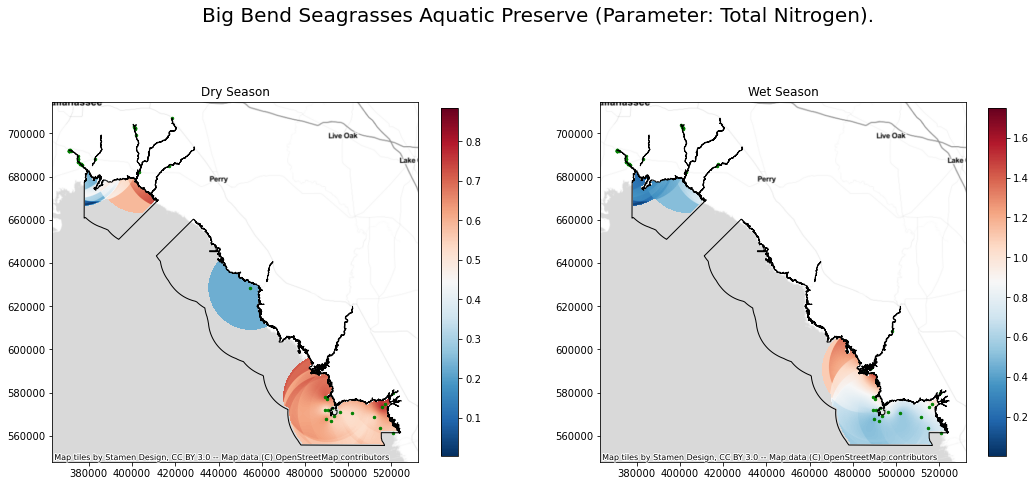

In [60]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2014, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2014, 'Wet Season', axes[1], fig)

## 8.2 Inverse Distance Weighting: Total Nitrogen <a class="anchor" id="tn_idw"></a>

In [61]:
year, season, method, value_field, mask = '2014', 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())
wetIDW_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)


Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 23.848767042160034 seconds ---
Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 23.305545806884766 seconds ---


C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


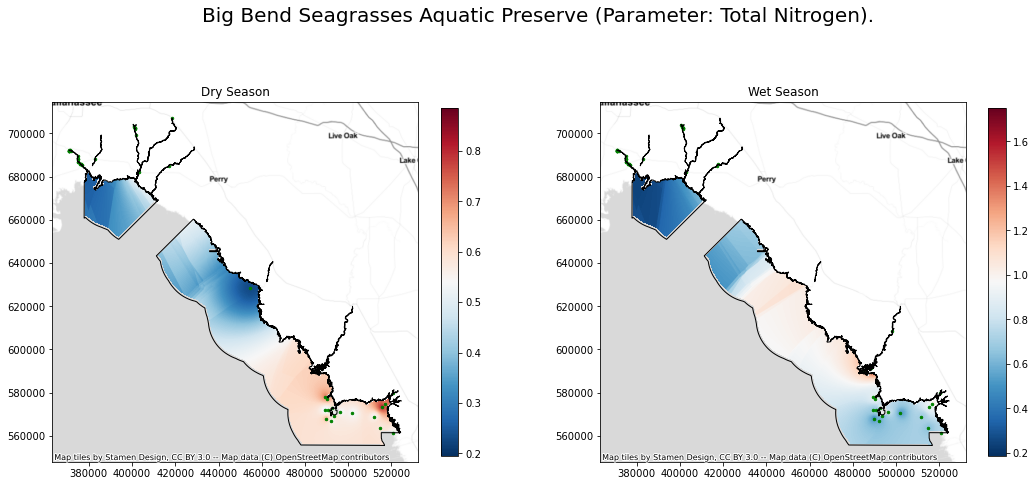

In [62]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2014, 'Wet Season', axes[1],fig)

## 8.3 Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_ebk"></a>

In [63]:
year, season, method, value_field, mask = '2014', 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())
wetEBK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 53.87649703025818 seconds ---
Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 64.33218669891357 seconds ---


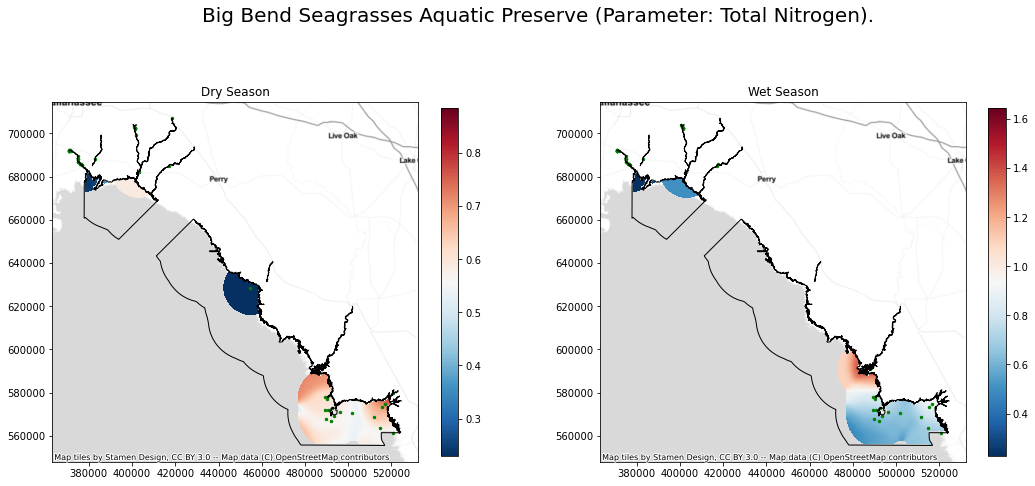

In [64]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2014, 'Wet Season', axes[1],fig)

## 8.4 Regression Kriging: Total Nitrogen <a class="anchor" id="tn_rk"></a>

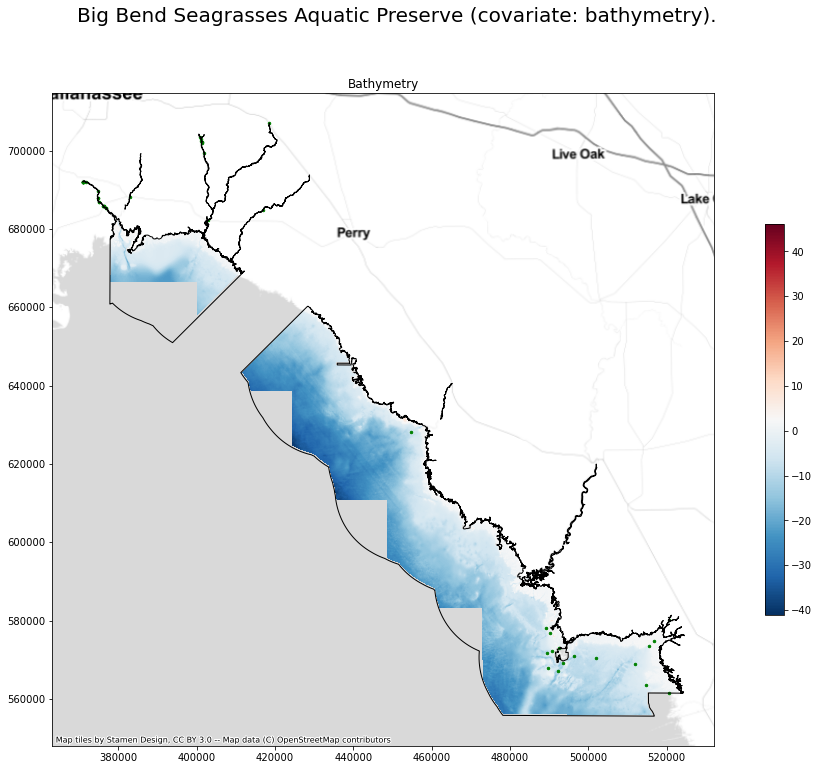

In [65]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax, fig)

In [66]:
year, season, method, value_field, mask = '2014', 'Dry','rk','ResultValu', boundary_shp 
in_explanatory_rasters = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])

in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetRK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 159.3463282585144 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 152.1425666809082 seconds ---


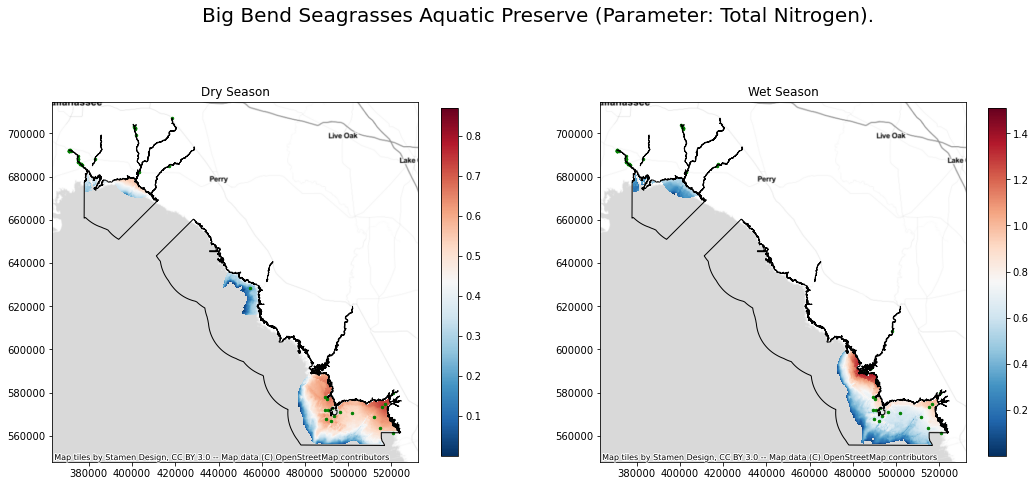

In [67]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2014, 'Wet Season', axes[1],fig)

# 9. Validation of Interpolation: Total Nitrogen <a class="anchor" id="tn_validation"></a>
## 9.1. Validation of Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_val_ok"></a>


In [68]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,-0.006102,-0.008416,0.226563


Interpolation assessment of Ordinary Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.000348,0.00062,0.216532


## 9.2. Validation of IDW: Total Nitrogen <a class="anchor" id="tn_val_idw"></a>


In [69]:
method, season, index = 'idw', 'dry', 'Inverse Distance Weighting'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryIDWStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'idw', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetIDWStat = misc.interpolation.extract_val_result(inLayer,index)

In [70]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,-0.0404,NaN,0.2953


Interpolation assessment of Inverse Distance Weighting in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Inverse Distance Weighting,-0.029,NaN,0.297


## 9.3. Validation of Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_val_ebk"></a>


In [71]:
method, season, index = 'ebk', 'dry', 'Empirical Bayesian Kriging'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryEBKStat = misc.interpolation.extract_val_result(inLayer,index)

method, season = 'ebk', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetEBKStat = misc.interpolation.extract_val_result(inLayer,index)

In [72]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,-0.0036,-0.0164,0.179


Interpolation assessment of Empirical Bayesian Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Empirical Bayesian Kriging,-0.0,0.0008,0.2256


## 9.4. Validation of Regression Kriging: Total Nitrogen <a class="anchor" id="tn_val_rk"></a>

In [73]:
method, season, index = 'rk', 'dry', 'Regression Kriging'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

dryRKStat = misc.interpolation.extract_val_result(inLayer,index)

season = 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

wetRKStat = misc.interpolation.extract_val_result(inLayer,index)

In [74]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,-0.0181,-0.0778,0.2034


Interpolation assessment of Regression Kriging in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Regression Kriging,-0.017,-0.0508,0.2414


## 9.5 Validation Summary of Total Nitrogen <a class="anchor" id="#tn_val_sum"></a>

In [76]:
sumStatDry3 = pd.concat([dryOKStat,dryIDWStat, dryEBKStat,dryRKStat])
sumStatWet3 = pd.concat([wetOKStat,wetIDWStat, wetEBKStat,wetRKStat])

print("Summary of interpolation assessment in dry season data")
display(sumStatDry3)

print("Summary of interpolation assessment in wet season data")
display(sumStatWet3)

Summary of interpolation assessment in dry season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,-0.006102,-0.008416,0.226563
Inverse Distance Weighting,-0.040400,NaN,0.295300
Empirical Bayesian Kriging,-0.003600,-0.016400,0.179000
Regression Kriging,-0.018100,-0.077800,0.203400


Summary of interpolation assessment in wet season data


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.000348,0.00062,0.216532
Inverse Distance Weighting,-0.029000,NaN,0.297000
Empirical Bayesian Kriging,-0.000000,0.00080,0.225600
Regression Kriging,-0.017000,-0.05080,0.241400


# 10. Validation Summary: All three variables <a class="anchor" id="val_sum"></a>

In [77]:
print("Summary of validation result in dry season data: dissolved oxygen")
display(sumStatDry)
print("Summary of validation result in wet season data: dissolved oxygen")
display(sumStatWet)

print("Summary of validation result in dry season data: salinity")
display(sumStatDry2)
print("Summary of validation result in wet season data: salinity")
display(sumStatWet2)

print("Summary of validation result in dry season data: total nitrogen")
display(sumStatDry3)
print("Summary of validation result in wet season data: total nitrogen")
display(sumStatWet3)

Summary of validation result in dry season data: dissolved oxygen


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.001124,0.00038,1.168835
Inverse Distance Weighting,-0.033900,NaN,1.214500
Empirical Bayesian Kriging,-0.010600,-0.00990,1.113700
Regression Kriging,0.040600,0.03850,1.093200


Summary of validation result in wet season data: dissolved oxygen


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.011823,0.00437,1.451679
Inverse Distance Weighting,0.036600,NaN,1.606300
Empirical Bayesian Kriging,-0.017000,-0.01190,1.437400
Regression Kriging,-0.000600,-0.00010,1.432700


Summary of validation result in dry season data: salinity


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.063675,0.008914,3.432846
Inverse Distance Weighting,-0.026400,NaN,4.052200
Empirical Bayesian Kriging,0.044600,-0.001400,3.515500
Regression Kriging,-0.012700,-0.014000,3.431400


Summary of validation result in wet season data: salinity


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.063218,0.009662,3.557056
Inverse Distance Weighting,-0.161600,NaN,4.116700
Empirical Bayesian Kriging,0.053600,0.005000,3.591200
Regression Kriging,0.004000,-0.002100,3.605100


Summary of validation result in dry season data: total nitrogen


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,-0.006102,-0.008416,0.226563
Inverse Distance Weighting,-0.040400,NaN,0.295300
Empirical Bayesian Kriging,-0.003600,-0.016400,0.179000
Regression Kriging,-0.018100,-0.077800,0.203400


Summary of validation result in wet season data: total nitrogen


,meanError,meanStandardizedError,rootMeanSquareError
Ordinary Kriging,0.000348,0.00062,0.216532
Inverse Distance Weighting,-0.029000,NaN,0.297000
Empirical Bayesian Kriging,-0.000000,0.00080,0.225600
Regression Kriging,-0.017000,-0.05080,0.241400
